In [1]:
import pickle
import keras
import tensorflow as tf
#from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
import helpers.data_generator
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
# from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
# from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
#from utils.callbacks import CyclicLR, TensorBoardWrapper
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm
from sklearn import preprocessing
from sklearn import decomposition
#import tkinter as tk
#from tkinter import filedialog
#root = tk.Tk()
#root.withdraw()

Using TensorFlow backend.
/home/lzfang/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lzfang/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lzfang/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lzfang/.conda/envs/tfgpu/l

In [2]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 2
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

In [3]:
# full_data_path = '/scratch/gpfs/jabbate/old_stuff/new_data/final_data.pkl'
full_data_path = '/scratch/gpfs/jabbate/full_data/train_data.pkl'

test_data_path = '/scratch/gpfs/jabbate/full_data/test_data.pkl' 
# profiles = ['thomson_temp_EFITRT1','thomson_dens_EFITRT1','temp','dens']
profiles = ['temp','dens','rotation','itemp','idens','press_EFIT01','q_EFIT01','press_EFIT02','q_EFIT02',]
# for profile in tqdm(profiles):
traindata, valdata, normalization_dict = helpers.data_generator.process_data(full_data_path,
                                                      profiles,
                                                      normalization_method='RobustScaler',
                                                      window_length=1,
                                                      window_overlap=0,
                                                      lookbacks=0,
                                                      lookahead=4,
                                                      sample_step=1,
                                                      uniform_normalization=True,
                                                      train_frac=1,
                                                      val_frac=0,
                                                      nshots=10000,
                                                      verbose=2,
                                                      flattop_only=True,
                                                      randomize=False,
                                                      pruning_functions=['remove_nan',
                                                                         'remove_dudtrip',
                                                                         'remove_I_coil',
                                                                         'remove_non_gas_feedback',
                                                                         'remove_ECH','remove_outliers'],
                                                      excluded_shots=['topology_TOP', 
                                                                      'topology_OUT',
                                                                      'topology_MAR',
                                                                      'topology_IN',
                                                                      'topology_DN',
                                                                      'topology_BOT'],
                                                      delta_sigs=[],
                                                      invert_q=True,
                                                      val_idx = 0)


Loading
Signals: dens, idens, itemp, press_EFIT01, press_EFIT02, q_EFIT01, q_EFIT02, rotation, temp
Number of useable shots:  4786
Number of shots used:  4786
Total number of timesteps:  508969
Shots with Complete NaN: 
346737 samples total
Removing ECH
Removed 141421 samples
205316 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 36992 samples
168324 samples remaining
Removing weird I-coils
Removed 35642 samples
132682 samples remaining
Removing NaN
Removed 0 samples
132682 samples remaining
Removing dudtrip
Removed 5667 samples
127015 samples remaining
Removing jagged q profiles
Removed 86 samples
126929 samples remaining
Removing zero q profiles
Removed 8958 samples
117971 samples remaining
Removing outlier pressure profiles
Removed 55 samples
117916 samples remaining
Removing negative pressure profiles
Removed 13717 samples
104199 samples remaining
Removing negative pressure profiles
Removed 3023 samples
101176 samples remaining
101176 samples remaining after pruni

In [6]:
traindata = denormalize(traindata,normalization_dict)

Denormalizing: 100%|##########| 18/18 [00:00<00:00, 24.07it/s]


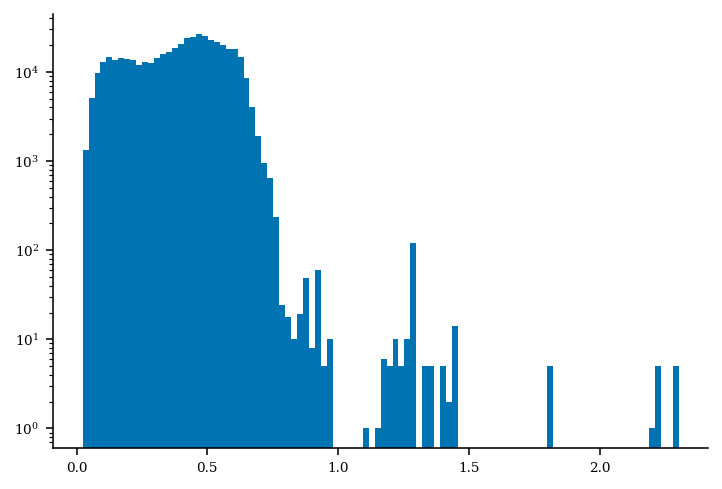

In [4]:
plt.hist(np.std(traindata['q_EFIT02'][:,:,:50],axis=-1).flatten(),bins=100,log=True);

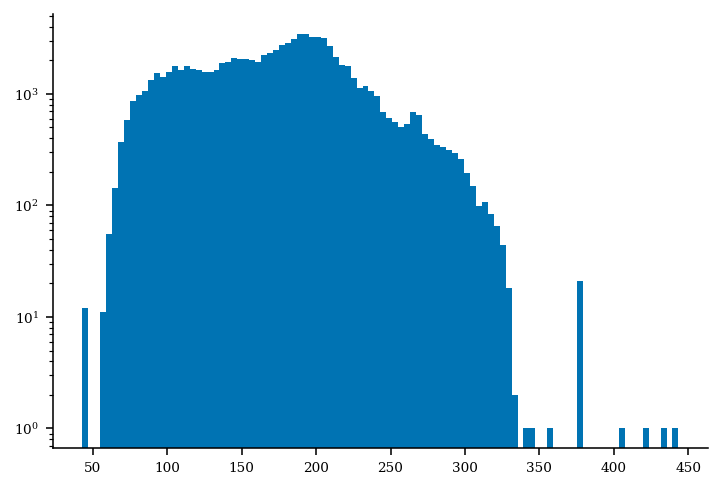

In [5]:
plt.hist(np.sum(np.abs(traindata['q_EFIT02']),axis=(1,2)),bins=100, log=True);

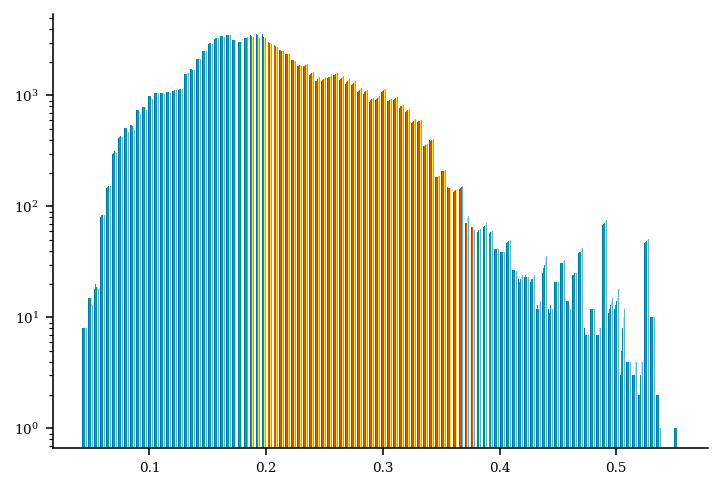

In [6]:
plt.hist(np.log10(np.mean(np.abs(traindata['press_EFIT02'])+1,axis=-1)), bins=100, log=True);

In [7]:
train_generator = DataGenerator(traindata,
                                1,
                                profiles,
                                [],
                                profiles,
                                [],
                                {profile:0 for profile in profiles},
                                4,
                                True,
                                2,
                                False,
                                sample_weights=None)

In [8]:
train_generator[0][0]['input_temp'].shape

(1, 1, 33)

In [9]:
num_components=10
full_pca_fitters = {}
delta_pca_fitters = {}

for profile in profiles:
    full = np.array([train_generator[i][0]['input_' + profile] for i in range(len(train_generator))]).squeeze()
    delta = np.array([train_generator[i][1]['target_' + profile] for i in range(len(train_generator))]).squeeze()
    print(profile, ' made arrays')
    full_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(full)
    print(profile, ' done full')
    delta_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(delta)
    print(profile, ' done deltas')


temp  made arrays
temp  done full
temp  done deltas
dens  made arrays
dens  done full
dens  done deltas
rotation  made arrays
rotation  done full
rotation  done deltas
itemp  made arrays
itemp  done full
itemp  done deltas
idens  made arrays
idens  done full
idens  done deltas
press_EFIT01  made arrays
press_EFIT01  done full
press_EFIT01  done deltas
q_EFIT01  made arrays
q_EFIT01  done full
q_EFIT01  done deltas
press_EFIT02  made arrays
press_EFIT02  done full
press_EFIT02  done deltas
q_EFIT02  made arrays
q_EFIT02  done full
q_EFIT02  done deltas


In [13]:
with open('/projects/EKOLEMEN/profile_predictor/full_pca_fitters.pkl','wb+') as f:
    pickle.dump(full_pca_fitters,f)
with open('/projects/EKOLEMEN/profile_predictor/delta_pca_fitters.pkl','wb+') as f:
    pickle.dump(delta_pca_fitters,f)

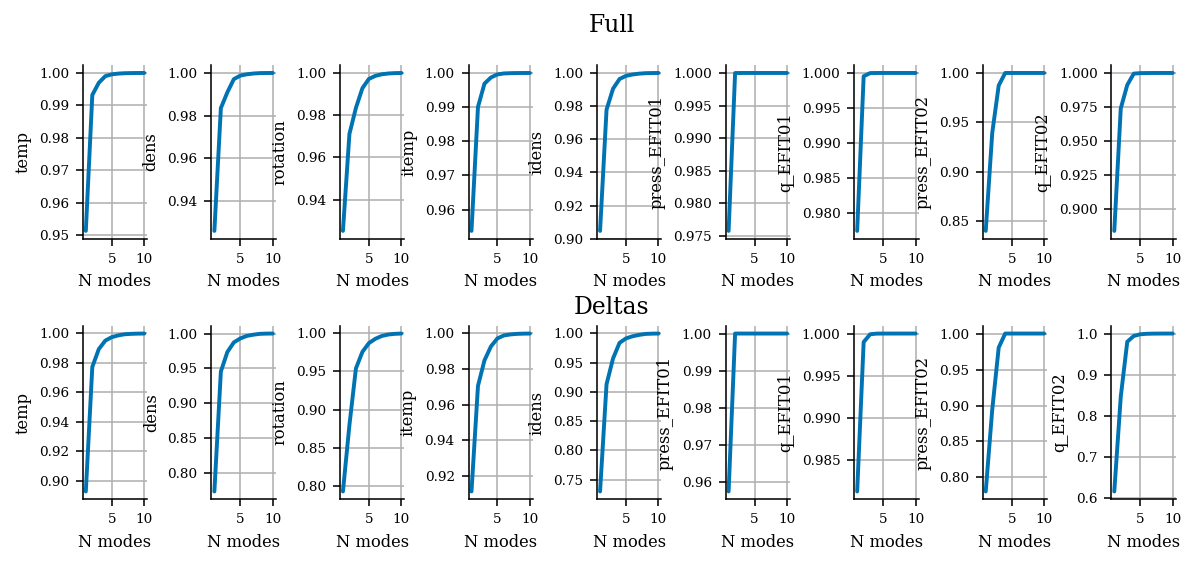

In [10]:
"""plot explained variance"""

ylabels = profiles #['$n_e$','$T_e$','$q$','$\Omega$','$P$']

fig, axes = plt.subplots(2,len(profiles),sharey=False,figsize=(10,4))
for j,profile in enumerate(profiles):
    pca=full_pca_fitters[profile]
    ax = axes[0,j]
    
    ax.plot(np.arange(1,pca.n_components+1),np.cumsum(pca.explained_variance_ratio_))
    ax.set_ylabel(ylabels[j])
    ax.set_xlabel('N modes')
    ax.grid()
    
    pca = delta_pca_fitters[profile]
    ax = axes[1,j]
    
    ax.plot(np.arange(1,pca.n_components+1),np.cumsum(pca.explained_variance_ratio_))
    ax.set_ylabel(ylabels[j])
    ax.set_xlabel('N modes')
    ax.grid()
fig.text(0.5, 0.95, 'Full', va='center', ha='center', fontsize=12)
fig.text(0.5, 0.45, 'Deltas', va='center', ha='center', fontsize=12)
plt.subplots_adjust(wspace=1.,hspace=.5)


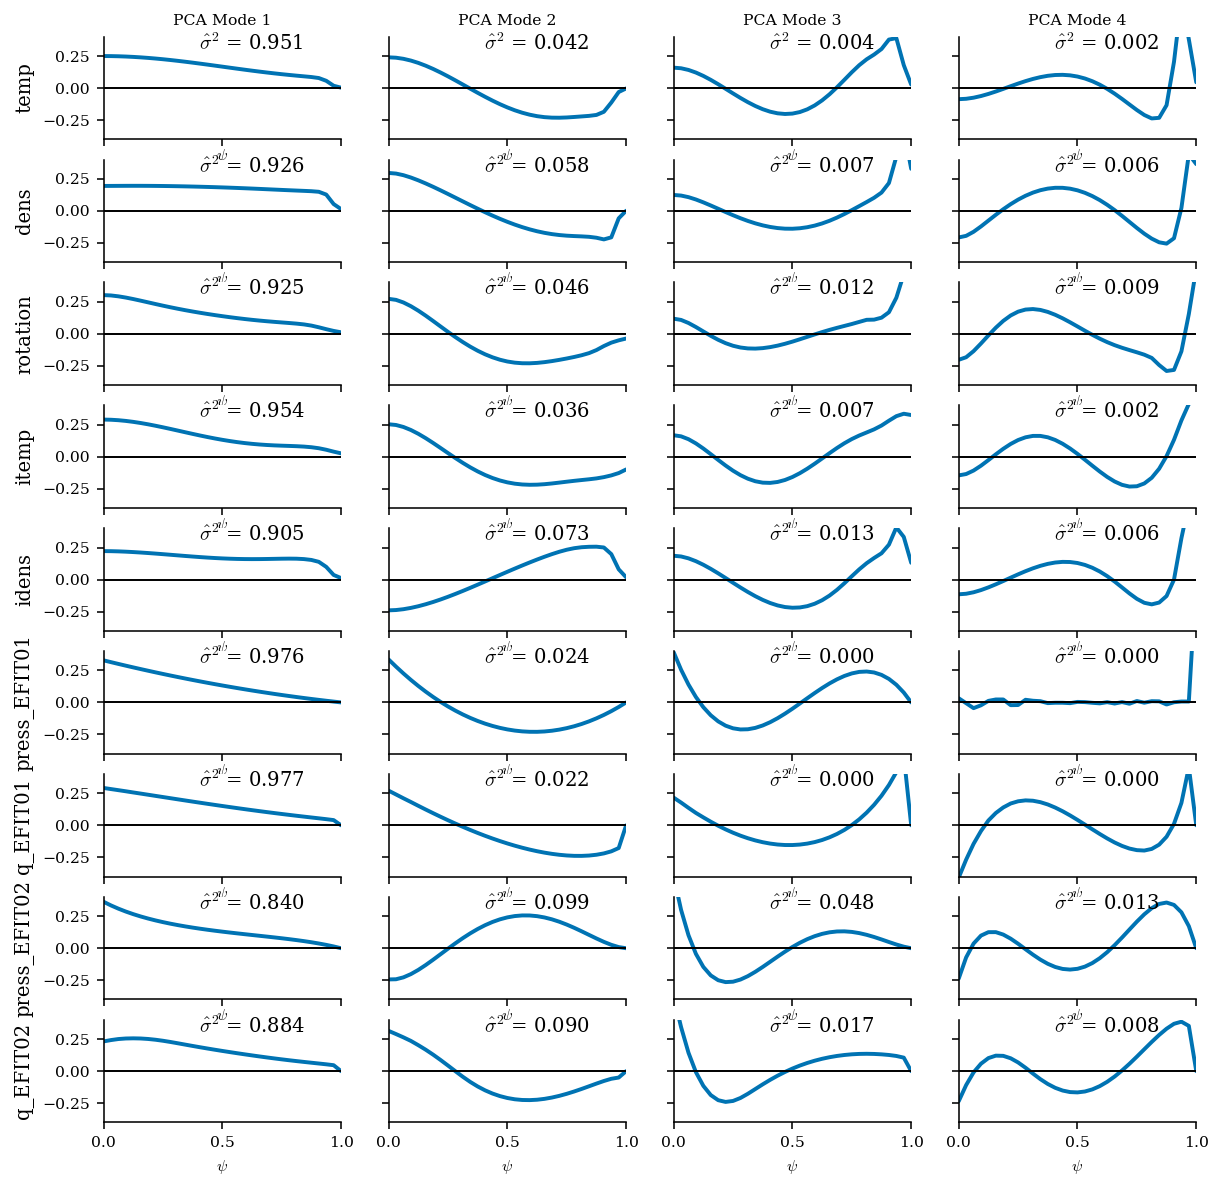

In [11]:
"""plot full pca modes"""

ncols = 4
ylabels = profiles
fig, axes = plt.subplots(len(profiles),ncols, sharex=True, sharey=True,figsize=(10,10))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))

psi = np.linspace(0,1,33)
labels = profiles
for i,profile in enumerate(profiles):
    pca=full_pca_fitters[profile]
    for j in range(ncols):
        ax= axes[i,j]
        ax.plot(psi,pca.components_[j],lw=2)
        ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca.explained_variance_ratio_[j]),fontsize=labelsize)
        if j==0:
            ax.set_ylabel(labels[i], size=labelsize)
        if i==0:
            ax.set_title('PCA Mode {}'.format(j+1), size=8)
        ax.set_xlabel('$\psi$',size=8)
        ax.set_ylim(-.4,.4)
        ax.tick_params(axis='both', which='major', labelsize=ticksize)
        ax.set_xticks([0,.5,1])
        ax.set_xlim(0,1)

        ax.axhline(0,c='k',lw=1)


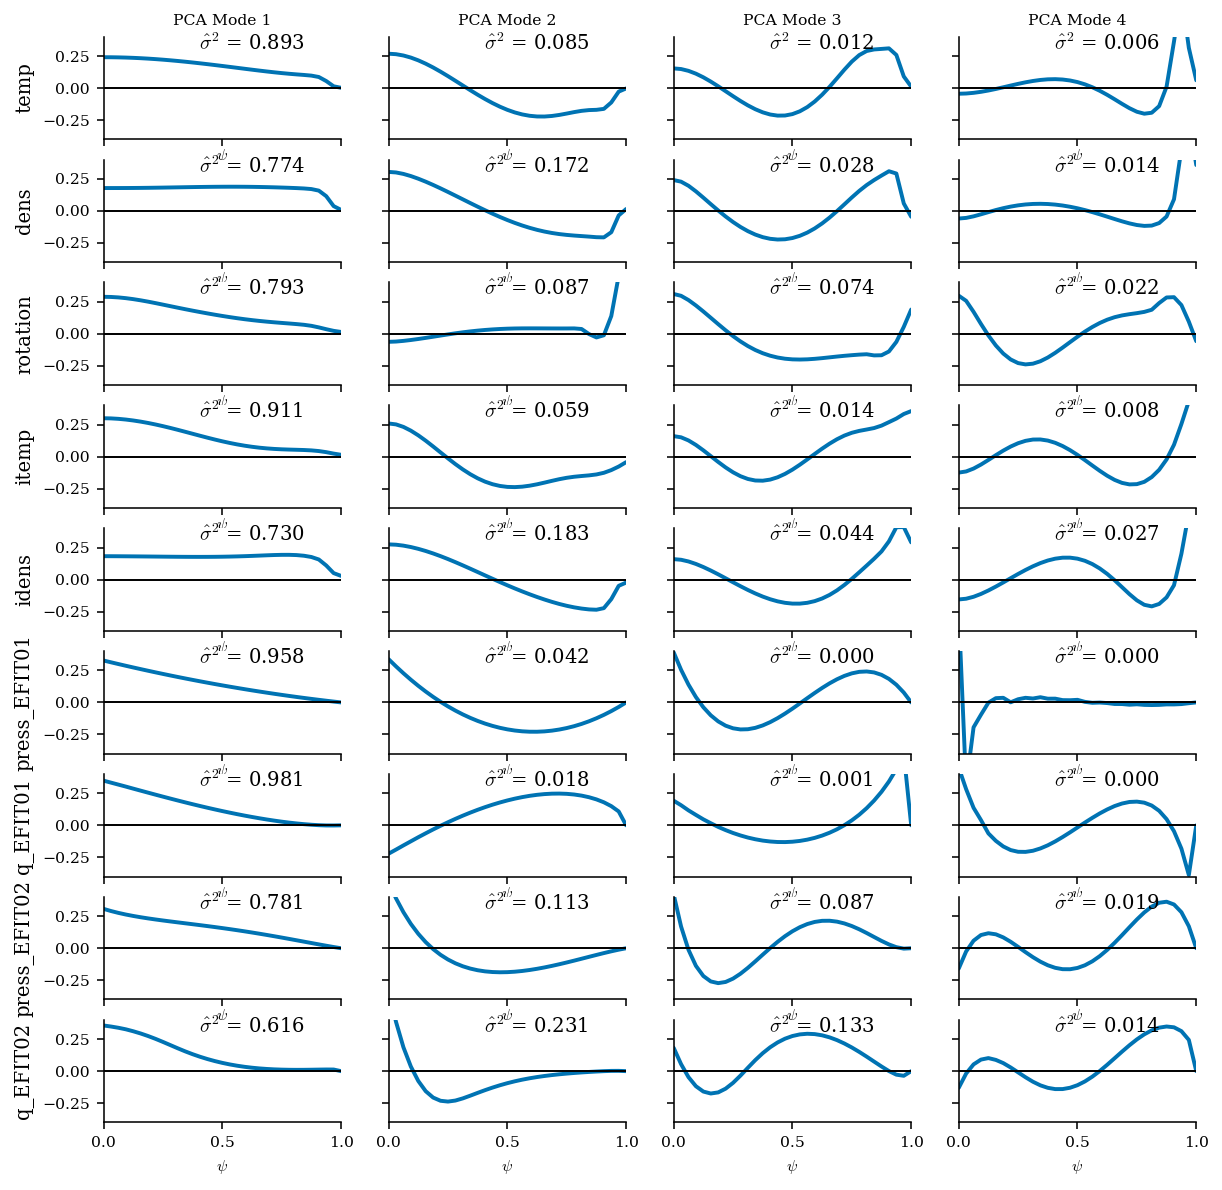

In [12]:
"""plot delta pca modes"""

ncols = 4
ylabels = profiles
fig, axes = plt.subplots(len(profiles),ncols, sharex=True, sharey=True,figsize=(10,10))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))

psi = np.linspace(0,1,33)
labels = profiles
for i,profile in enumerate(profiles):
    pca=delta_pca_fitters[profile]
    for j in range(ncols):
        ax= axes[i,j]
        ax.plot(psi,pca.components_[j],lw=2)
        ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca.explained_variance_ratio_[j]),fontsize=labelsize)
        if j==0:
            ax.set_ylabel(labels[i], size=labelsize)
        if i==0:
            ax.set_title('PCA Mode {}'.format(j+1), size=8)
        ax.set_xlabel('$\psi$',size=8)
        ax.set_ylim(-.4,.4)
        ax.tick_params(axis='both', which='major', labelsize=ticksize)
        ax.set_xticks([0,.5,1])
        ax.set_xlim(0,1)

        ax.axhline(0,c='k',lw=1)

Text(0.5, 1.0, '   temp                          dens                        rotation                       itemp                         idens   ')

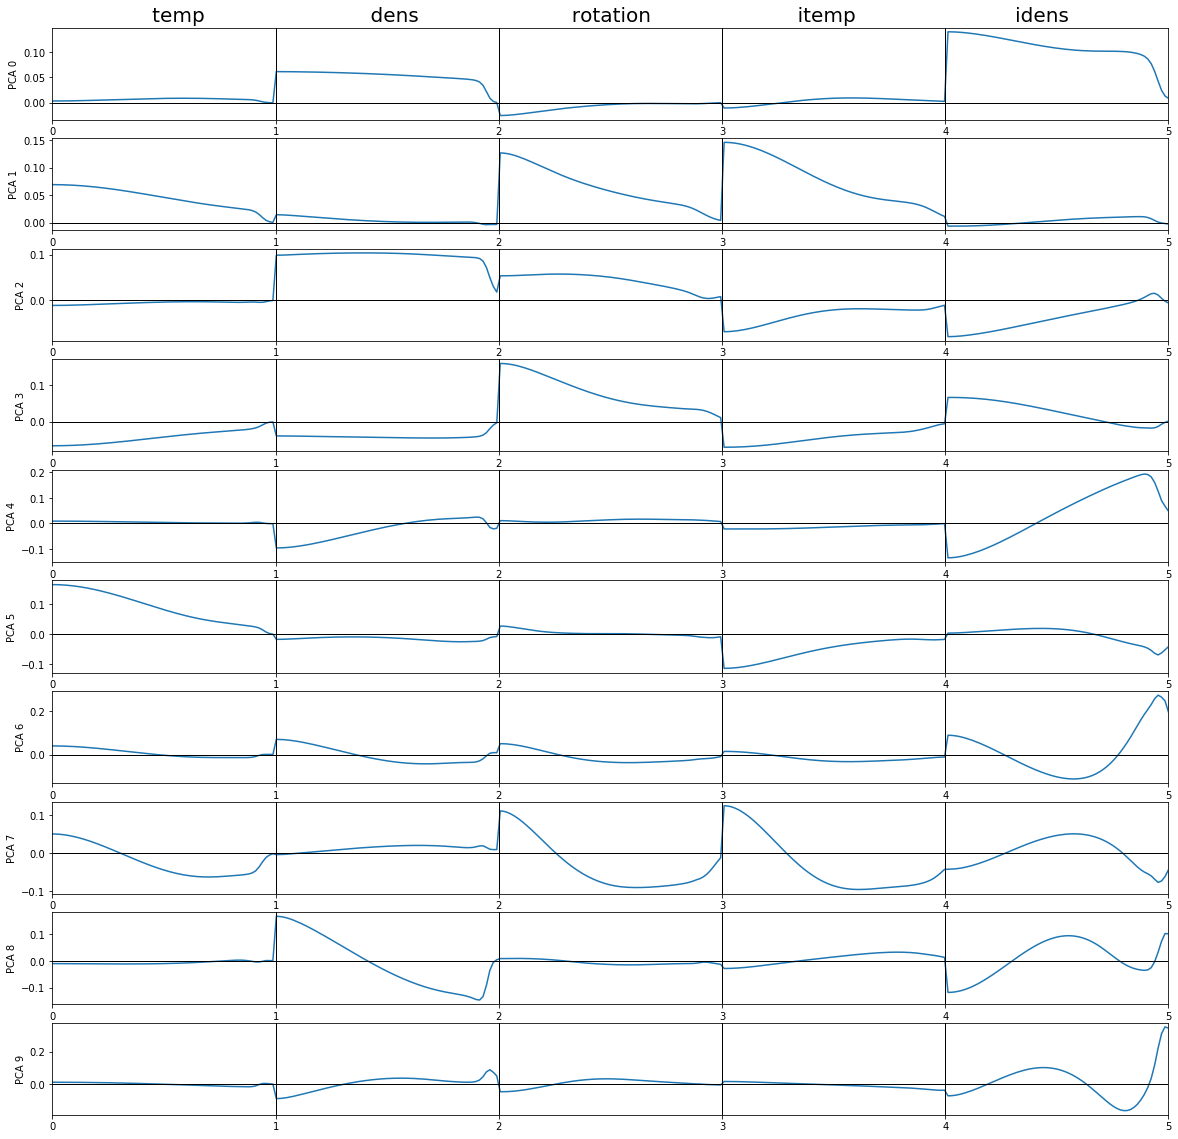

In [67]:
nmodes=10
fig, ax = plt.subplots(nmodes,1,figsize=(20,2*nmodes))
psi = np.linspace(0,len(profiles),X.shape[-1])
for i in range(nmodes):
    ax[i].plot(psi,fitter.components_[i,:])
    ax[i].set_ylabel('PCA {}'.format(i))
    ax[i].axhline(0,color='k',linewidth=1)
    ax[i].set_xlim((0,len(profiles)))
    for j in range(1,len(profiles)):
        ax[i].axvline(j,color='k',linewidth=1)
ax[0].set_title('                    '.join([profile.center(10) for profile in profiles]),size=20)


In [74]:
N = 40 # parameters
M = 150 # measurements
A = np.random.random((M,N))
b = np.random.random(M)


In [75]:
%%timeit
x = np.linalg.lstsq(A,b)

/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


806 µs ± 87.5 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
# with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_fitters.pkl'),'wb+') as f:
#     pickle.dump(full_pca_fitter,f)
# with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_kernels.pkl'),'wb+') as f:
#     pickle.dump(kernels,f)

with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_fitters.pkl'),'rb') as f:
    full_pca_fitter = pickle.load(f, encoding='latin1')
with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_kernels.pkl'),'rb') as f:
    kernels = pickle.load(f, encoding='latin1')

In [50]:
kernels['temp']['variance']

array([4.11242985e-02, 5.71169228e-03, 2.47462692e-03, 9.47234419e-04,
       4.93366018e-04, 2.43511649e-04, 9.74272177e-05, 4.16170028e-05,
       9.13944222e-06, 2.92965849e-06])

Text(0.5, 0.98, 'Shot: 167472 Time: 1750 ms')

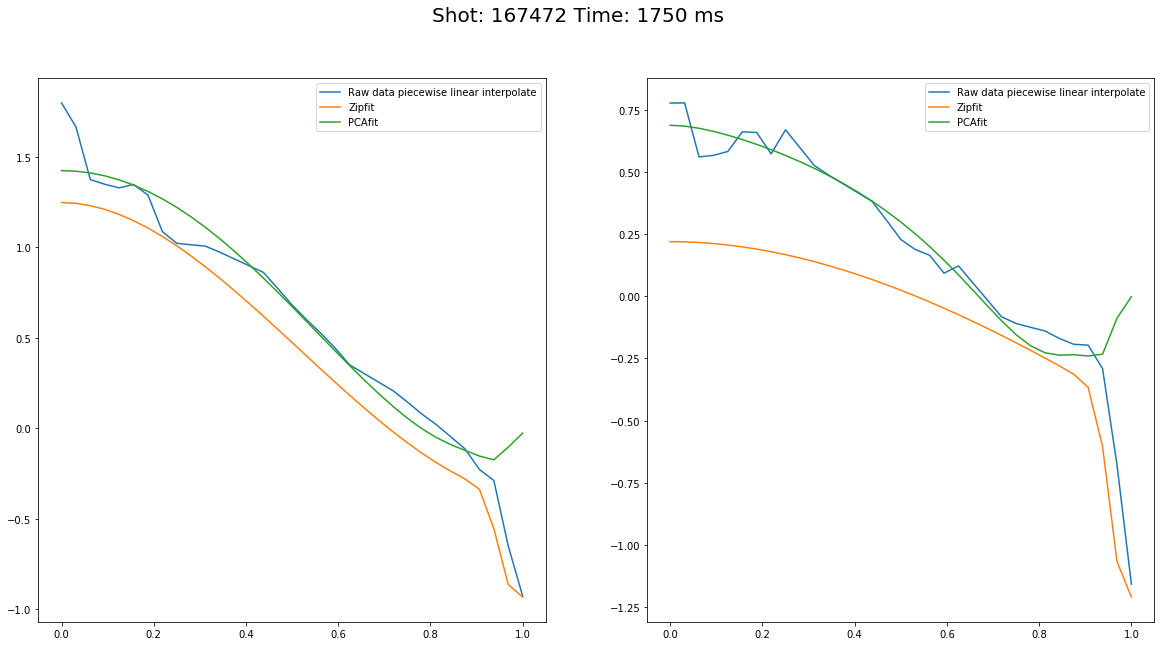

In [55]:
idx = np.random.randint(traindata['temp'].shape[0])
psi = np.linspace(0,1,33)

shotnum = int(traindata['shotnum'][idx][0])
time = int(traindata['time'][idx][0])

temp_zipfit = traindata['temp'][idx,0,::2]
temp_raw = traindata['thomson_temp_EFITRT1'][idx,0,::2]
temp_pcafit = np.dot(temp_raw,kernels['temp'][3])

dens_zipfit = traindata['dens'][idx,0,::2]
dens_raw = traindata['thomson_dens_EFITRT1'][idx,0,::2]
dens_pcafit = np.dot(dens_raw,kernels['dens'][3])


fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(psi,temp_raw, label='Raw data piecewise linear interpolate')
ax[0].plot(psi,temp_zipfit, label='Zipfit')
ax[0].plot(psi,temp_pcafit, label='PCAfit')
ax[0].legend()

ax[1].plot(psi,dens_raw, label='Raw data piecewise linear interpolate')
ax[1].plot(psi,dens_zipfit, label='Zipfit')
ax[1].plot(psi,dens_pcafit, label='PCAfit')
ax[1].legend()

fig.suptitle('Shot: {} Time: {} ms'.format(shotnum,time),size=20)
